## Setup

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [152]:
def se_kernel(a, b, l = 1):
    '''
    Finds the squared exponential correlation matrix between two datasets [a] and [b].

    @param a
        A (d, n) matrix corresponding to n input vectors of dimension d.
    @param b
        A (d, m) matrix corresponding to m input vectors of dimension d.
    @return
        The (n, m) correlation matrix between [a] and [b].
    '''
    (d, n) = a.shape
    a2 = np.sum(a**2, 0) # 1 by n, magnitude of each column
    b2 = np.sum(b**2, 0) # 1 by m
    r2 = a2.reshape(n,1) + b2 # n by m, the sum broadcasts both vectors
    r2 = r2 - 2 * np.dot(a.T, b)
    return np.exp(-.5 / l**2 * r2)

def se_kernel_1(a, b):
    return se_kernel(a, b, 1)

In [13]:
def sample_normal(mean, cov, samples = 1):
    '''
    Samples [samples] times from a multivariate normal distribution given the
    mean and the covariance.

    @param mean
        A vector of size (n) corresponding to the means of the distribution.
    @param cov
        The covariance matrix of size (n, n).
    @return
        The matrix of sampled points of size (n, samples).
    '''
    n = cov.shape[0]

    # Given a normal distribution N(u, K), we convert this to a standard normal using the 
    # Cholesky decomposition, N(u, K) = u + L * N(0, I). The added identity term is to 
    # prevent numerical instability that may cause the correlation matrix to be not 
    # positive definite.
    L = np.linalg.cholesky(cov + 1e-10 * np.eye(n)) # (n, n)

    # Samples from a standard normal
    y = np.random.normal(size=(n, samples)) # (n, samples)

    return mean.reshape(n, 1) + L.dot(y) # (n, samples)

In [14]:
def std_dev(cov):
    '''
    Extracts the standard deviations given a covariance matrix.

    @param cov
        A (n, n) covariance matrix
    @return
        The (n) standard deviations
    '''
    return np.sqrt(np.diag(cov))

In [15]:
def get_posterior(X_train, y_train, X_test, kernel = se_kernel_1, y_noise = 1e-10):
    '''
    Calculates the posterior mean and covariance, along with the prior covariance,
    given a set of training and testing points.

    @param X_train
        A (d, n) matrix corresponding to n training points of dimension d.
    @param y_train
        A (n) vector corresponding to the target values.
    @param X_test
        A (d, m) matrix corresponding to m testing points of dimension d.
    @param kernel
        A kernel function (A, B) -> C to define the process. It should accept 
        input matrices of dimension (d, n) and (d, m) respectively, corresponding 
        to input vectors of dimension d, and output the (n, m) correlation matrix 
        between A and B.
    @param y_noise
        Noise to apply to the training targets. Don't set this to 0, as some noise
        helps prevent numerical instability. 
    @return
        A tuple (prior covariance, posterior mean, posterior covariance).
        The covariances are (m, m) matrices and the mean is a (m) vector.
    '''
    n = X_train.shape[1]
    m = X_test.shape[1]

    K_XX = kernel(X_train, X_train) # (n, n)
    K_XY = kernel(X_train, X_test)  # (n, m)
    K_YY = kernel(X_test, X_test)   # (m, m)

    L = np.linalg.cholesky(K_XX + y_noise * np.eye(n)) # (n, n)
    v = np.linalg.solve(L, K_XY) # (n, m)
    temp = np.linalg.solve(L, y_train) # (n)

    mean_post = v.T.dot(temp) # (m)
    cov_prior = K_YY # (m, m)
    cov_post = K_YY - np.dot(v.T, v) # (m, m)

    return cov_prior, mean_post, cov_post

In [16]:
def plot_gp(X, mean, cov, samples = 4):
    '''
    Plots samples from a 1D Gaussian process given the mean and covariance.
    The samples are drawn as solid lines, the mean is shown as a dashed line,
    and the 2-sigma range is shaded in gray. 
     
    @param X
        A (1, n) matrix of the input values.
    @param mean
        A (n) vector of the means
    @param cov
        The (n, n) covariance matrix
    @param samples
        The number of random samples to draw from the process.
    '''
    if X.shape[0] != 1:
        raise RuntimeError(f'Inputs should be 1-dimensional, got {X.shape}')

    x = X[0] # (n)
    std = std_dev(cov) # (n)
    f = sample_normal(mean, cov, samples) # (n, samples)

    plt.plot(x, mean, 'k--')
    plt.plot(x, f)
    plt.gca().fill_between(x, mean - 2*std, mean + 2*std, color="#dddddd")

## Test Bench

Edit these as you please! Note that their shapes should be consistent though.

In [231]:
X_train = np.array([[-4, -3, 0, 2]]) # (1, n)
y_train = np.sin(X_train).reshape(-1) # (n)

X_test = np.linspace(-5, 5, 200).reshape(1, -1) # (1, m)
mean_prior = np.zeros(X_test.shape[1]) # (m)

def kernel(x, y): return se_kernel(x, y, 1)

## Run

In [232]:
cov_prior, mean_post, cov_post = get_posterior(X_train, y_train, X_test, kernel = kernel)

Text(0.5, 1.0, 'Samples from the Gaussian process prior')

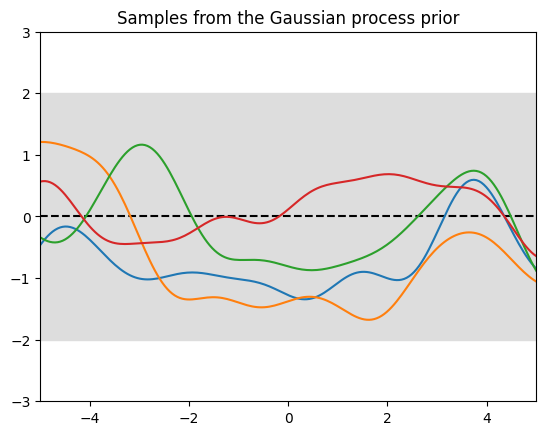

In [233]:
plot_gp(X_test, mean_prior, cov_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Samples from the Gaussian process prior')

Text(0.5, 1.0, 'Samples from the Gaussian process posterior')

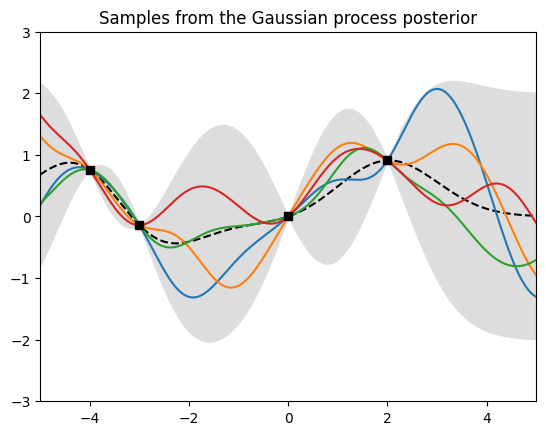

In [234]:
plot_gp(X_test, mean_post, cov_post)
plt.plot(X_train.T, y_train, 'ks') 
plt.axis([-5, 5, -3, 3])
plt.title('Samples from the Gaussian process posterior')

## Sklearn

In [193]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF, Matern

In [214]:
def plot_gp_scikit(gpr, X, samples = 4):
    '''
    Plots samples from a 1D Gaussian process given the mean and covariance.
    The samples are drawn as solid lines, the mean is shown as a dashed line,
    and the 2-sigma range is shaded in gray. 
     
    @param gpr
        A sklearn.gaussian_process.GaussianProcessRegressor object
    @param X
        A (1, n) matrix of the input values.
    @param samples
        The number of random samples to draw from the process.
    '''
    if X.shape[0] != 1:
        raise RuntimeError(f'Inputs should be 1-dimensional, got {X.shape}')

    mean, std = gpr.predict(X.T, return_std=True) # (n)
    f = gpr.sample_y(X.T, samples, random_state=None) # (n, samples)

    x = X[0] # (n)
    plt.plot(x, mean, 'k--')
    plt.plot(x, f)
    plt.gca().fill_between(x, mean - 2*std, mean + 2*std, color="#dddddd")

In [222]:
# kernel = RBF(length_scale=1, length_scale_bounds='fixed')
# kernel = Matern(nu=1.5, length_scale=1, length_scale_bounds='fixed')
kernel = RationalQuadratic(length_scale=1, alpha=2, length_scale_bounds='fixed', alpha_bounds='fixed')

Text(0.5, 1.0, 'Samples from the Gaussian process prior')

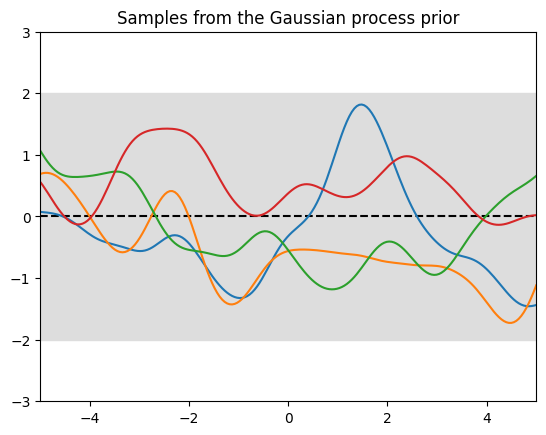

In [223]:
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=0)
plot_gp_scikit(gpr, X_test)
plt.axis([-5, 5, -3, 3])
plt.title('Samples from the Gaussian process prior')

Text(0.5, 1.0, 'Samples from the Gaussian process posterior')

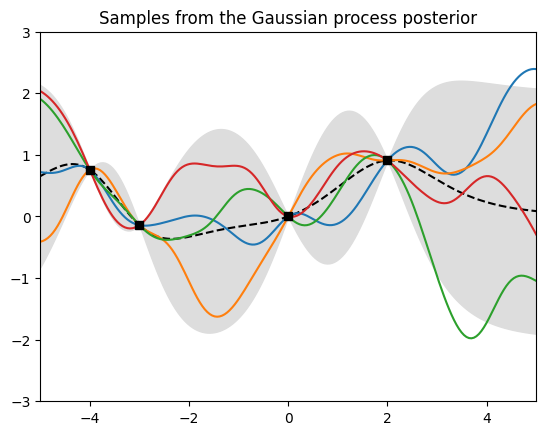

In [224]:
gpr.fit(X_train.T, y_train)
plot_gp_scikit(gpr, X_test)
plt.plot(X_train.T, y_train, 'ks')
plt.axis([-5, 5, -3, 3])
plt.title('Samples from the Gaussian process posterior')